Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 16.44 seconds, 1.83 sentences/sec


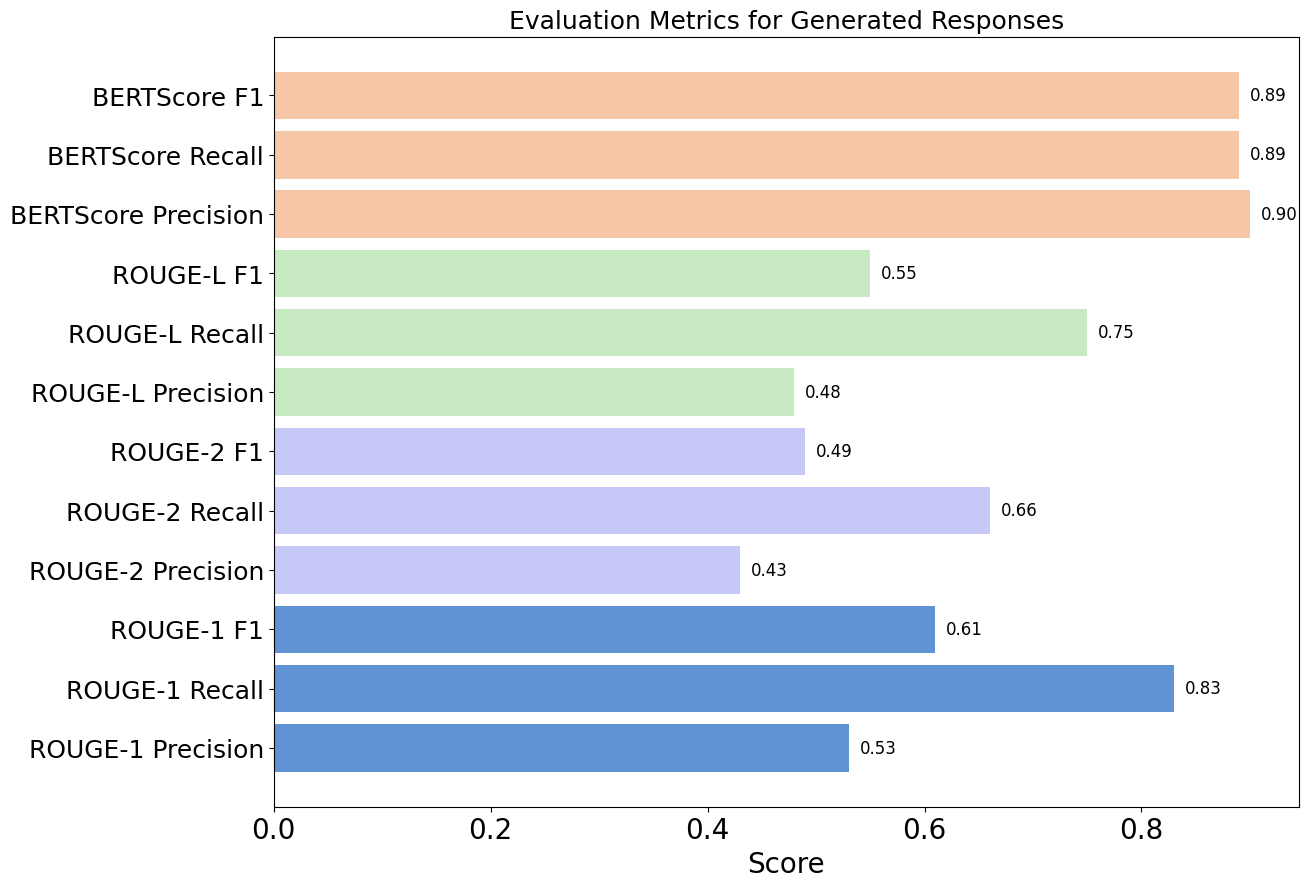

In [1]:
import pandas as pd
from rouge_score import rouge_scorer
import bert_score
import warnings
import numpy as np 
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')

# Load the CSV file with a specific encoding
file_path = 'Mineral_Commodity_Queries.csv'
df = pd.read_csv(file_path)

# Ensure all values are strings and handle missing values
df['Ground Truth'] = df['Ground Truth'].fillna('').astype(str)
df['Answer'] = df['answers'].fillna('').astype(str)

# Extract the ground truth and answer columns
ground_truths = df['Ground Truth'].tolist()
answers = df['Answer'].tolist()

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

# Calculate ROUGE scores
rouge_scores = [scorer.score(gt, ans) for gt, ans in zip(ground_truths, answers)]

# Calculate BERT scores using bert-score library
P, R, F1 = bert_score.score(answers, ground_truths, lang='en', verbose=True)

# Prepare the results in a DataFrame
results_df = pd.DataFrame({
    'Ground Truth': ground_truths,
    'Answer': answers,
    'ROUGE-1 Precision': [score['rouge1'].precision for score in rouge_scores],
    'ROUGE-1 Recall': [score['rouge1'].recall for score in rouge_scores],
    'ROUGE-1 F1': [score['rouge1'].fmeasure for score in rouge_scores],
    'ROUGE-2 Precision': [score['rouge2'].precision for score in rouge_scores],
    'ROUGE-2 Recall': [score['rouge2'].recall for score in rouge_scores],
    'ROUGE-2 F1': [score['rouge2'].fmeasure for score in rouge_scores],
    'ROUGE-L Precision': [score['rougeL'].precision for score in rouge_scores],
    'ROUGE-L Recall': [score['rougeL'].recall for score in rouge_scores],
    'ROUGE-L F1': [score['rougeL'].fmeasure for score in rouge_scores],
    'BERTScore Precision': P.numpy(),
    'BERTScore Recall': R.numpy(),
    'BERTScore F1': F1.numpy()
})
results_df_final = results_df.iloc[:,2:].mean(axis=0)
metrics = list(results_df_final.index)
scores = list(np.round(results_df_final.values,2))

# Define colors for each metric category
colors = ['#6093D4'] * 3 + ['#c6c8f8'] * 3 + ['#c8eac3'] * 3 + ['#f5c7a7'] * 3

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Horizontal bar graph
bars = ax.barh(metrics, scores, color=colors)

# Adding data labels
for bar in bars:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width():.2f}', 
            va='center', ha='left',fontsize=12)

# Adjust the plot margins to add padding on the right side
plt.subplots_adjust(right=1.15)

# Titles and labels
ax.set_xlabel('Score', fontsize=20)
ax.set_title('Evaluation Metrics for Generated Responses', fontsize=18)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=18)
plt.show()